In [340]:
import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
from scregat.model import train_scregat, explain_model_ig
import pickle

In [2]:
import pickle
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)
dataset_graph = ATACGraphDataset('./input_graph/')

In [3]:
test_cell = pd.read_csv('./test_cell_name.txt')['x'].values

In [337]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

seq_vec = torch.load('./seq.pth')

data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 
train_graph = []
test_graph = []
test_cell_type = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):

    seq_data = seq_vec
    sample.seq_data = seq_data
    sample.id_vec = torch_vector

    
    if sample.cell in test_cell:
        test_graph.append(sample)
        test_cell_type.append(sample.y.item())
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y.item())



Processing samples: 100%|██████████| 8821/8821 [00:01<00:00, 7779.77it/s]


In [683]:
import torch
import torch.nn as nn

class EdgeDiversityLoss1(nn.Module):
    def __init__(self, diversity_weight=1.0):
        """
        自定义多样性损失函数
        :param diversity_weight: 控制熵惩罚的权重
        """
        super(EdgeDiversityLoss1, self).__init__()
        self.diversity_weight = diversity_weight

    def forward(self, edge_weights):
        """
        计算自定义多样性损失
        :param edge_weights: 模型生成的边权重矩阵 (torch.Tensor)，形状为 (batch_size, num_edges)
        :return: 计算出的多样性损失 (torch.Tensor)
        """
        # 计算概率分布
        prob_distribution = torch.softmax(edge_weights, dim=0)

        # 计算熵损失，增大熵
        entropy_loss = -self.diversity_weight * torch.sum(prob_distribution * torch.log(prob_distribution + 1e-6), dim=0)

        # 总损失：使用熵作为多样性损失
        loss = torch.sum(entropy_loss)
        return loss


In [684]:
import torch
import torch.nn as nn

class EdgeDiversityLoss2(nn.Module):
    def __init__(self, non_zero_penalty_weight=1.0):
        """
        自定义多样性损失函数
        :param non_zero_penalty_weight: 控制非零惩罚的权重
        """
        super(EdgeDiversityLoss2, self).__init__()
        self.non_zero_penalty_weight = non_zero_penalty_weight

    def forward(self, edge_weights):
        """
        计算自定义多样性损失
        :param edge_weights: 模型生成的边权重矩阵 (torch.Tensor)，形状为 (batch_size, num_edges)
        :return: 计算出的多样性损失 (torch.Tensor)
        """
        # 筛选出非零元素
        non_zero_weights = edge_weights[edge_weights != 0]

        # 计算非零元素的方差并取负
        variance_loss = -torch.var(non_zero_weights)

        # 计算非零惩罚：惩罚零权重的数量
        non_zero_penalty = self.non_zero_penalty_weight * torch.sum((edge_weights == 0).float())

        # 总损失：使用负方差作为多样性损失和非零惩罚的组合
        loss = variance_loss + non_zero_penalty
        return loss


In [685]:
atten[1]

tensor([[0.0000, 0.0168, 0.0000,  ..., 0.0169, 0.0000, 0.0168],
        [0.0168, 0.0000, 0.0168,  ..., 0.0000, 0.0000, 0.0000],
        [0.0167, 0.0171, 0.0172,  ..., 0.0000, 0.0162, 0.0168],
        ...,
        [0.0168, 0.0000, 0.0170,  ..., 0.0000, 0.0000, 0.0169],
        [0.0000, 0.0168, 0.0000,  ..., 0.0169, 0.0000, 0.0168],
        [0.0169, 0.0000, 0.0168,  ..., 0.0169, 0.0170, 0.0168]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>)

In [686]:
atten[1].shape

torch.Size([285709, 16])

In [704]:
def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]

In [711]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=2,
                 node_output_dim=8,
                 edge_embedding_dim=8,
                 hidden_channels=16,  # 增加 hidden_channels
                 gat_input_channels=8,
                 gat_hidden_channels=8,  # 增加 GAT 隐藏通道
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.4,  # 增加 dropout
                 num_head_1=16,  # 增加 GAT 头数
                 num_head_2=16):  # 增加 GAT 头数
        super(SCReGAT, self).__init__()

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(3, 16),
            nn.LayerNorm(16),
            nn.LeakyReLU(),
            nn.Linear(16, edge_embedding_dim),
            nn.LeakyReLU()
        )

        # GAT layers with increased heads and self-loops
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(0.1)  
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        
        self.NN_cell_type = nn.Sequential(
            nn.Linear(1882, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 9),
            nn.Softmax()
        )
        

    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num, gene_id_vec, is_test=False):
        data = raw_x
        seq_data = self.NN_seq(seq_data)
        data = torch.cat((data, seq_data), dim=1)
        data = self.NN_node(data)
         
        hidden_edge_input = torch.cat((raw_x[edge_index[0]] * raw_x[edge_index[1]], raw_x[edge_index[0]], raw_x[edge_index[1]]), dim=1)
        hidden_edge = self.NN_edge(hidden_edge_input).sigmoid()
        
        model.edge = torch.median(hidden_edge, dim=1)[0]
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))

        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        
        data = data_1 + data_2
        self.data = data
        if is_test == False:
            cell_type = self.NN_cell_type(torch.mean(data[gene_id_vec==1], dim=1))
        else:
            cell_type = None
            pass
        gene_out = -F.log_softmax(data[gene_id_vec==1], dim=1)[:, 0]

        return gene_out, atten_w1, cell_type

import torch
import torch.nn as nn

In [712]:
sample.y_exp.shape

torch.Size([1882])

In [713]:
def get_split(mt, batch_size):
    edge_flattened = mt
    if edge_flattened.size(0) % batch_size == 0:
        split_edges = edge_flattened.split(edge_flattened.size(0) // batch_size)
    else:
        remainder = edge_flattened.size(0) % batch_size
        edge_flattened = edge_flattened[:-remainder]  # Drop the remainder
        split_edges = edge_flattened.split(edge_flattened.size(0) // batch_size)
    return torch.vstack(split_edges)

In [714]:
len(dataset_atac.array_celltype)

9

In [717]:
model = SCReGAT()

In [ ]:
import torch
import random
from tqdm import tqdm

gene_num = len(sample.y_exp)
device = 'cuda:0'
model.to(device)
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
# loss_exp = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 50
drop_edge_rate = 0.1
attention_reg_weight = 0.001
sparse_loss_weight = 0.01
batch_size = 1
criterion_sparse1 = EdgeDiversityLoss1(diversity_weight=1.0)
criterion_sparse2 = EdgeDiversityLoss2(non_zero_penalty_weight=1.0)
criterion2 = torch.nn.CrossEntropyLoss()
max_grad_norm = 1.0

def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]

train_loader = DataLoader(train_graph, batch_size=batch_size, shuffle=True)
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    running_loss1 = 0.0
    running_attention_loss = 0.0  # 记录 attention 正则化损失
    running_sparse_loss = 0.0  # 记录稀疏损失
    running_cell_loss = 0.0  # 记录 loss_cell
    

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")
    
    for idx, sample in enumerate(progress_bar):
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()
        edge_index_dropped = sample.edge_index
        gene_pre, atten, cell_pre = model(
            sample.seq_data.to(device),
            sample.x.to(device),
            sample.edge_index.to(device),
            sample.edge_tf.T.to(device),
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device)
        )
        
        index = torch.where(sample.id_vec == 1)[0]
        loss1 = -loss_exp(gene_pre.flatten(), sample.y_exp.to(device))
        loss_cell = criterion2(cell_pre.unsqueeze(0), sample.y.to(device))
        # attention_variance = torch.var(atten[1]).mean()
        # attention_loss = attention_reg_weight * (5.0 - attention_variance) 
                # 计算注意力得分的均值
    

        # 最终损失：包括多样性损失
        attention_loss = attention_reg_weight * criterion_sparse2(atten[1])

        edge_temp = model.edge.flatten()
        # loss2 = attention_reg_weight * (5.0 - torch.var(edge_temp).mean())
        loss2 = sparse_loss_weight * criterion_sparse1(edge_temp)
        loss = loss1 + attention_loss + loss_cell + loss2
        
        
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # 更新运行中的损失
        running_loss += loss.item()
        running_loss1 += loss1.item()
        running_attention_loss += attention_loss.item()  # 记录注意力正则化损失
        running_sparse_loss += loss2.item()  # 记录稀疏损失
        running_cell_loss += loss_cell.item()  # 记录 loss_cell
        
        if idx % 100 == 0:
            print(gene_pre, edge_temp, atten)
            print(f"gene_pre: {gene_pre}, loss_cell: {loss_cell.item()}, attention_loss: {attention_loss.item()}, sparse_loss: {loss2.item()}")
        
        # 更新进度条，显示平均损失
        progress_bar.set_postfix(
            loss=running_loss / (progress_bar.n + 1),
            loss1=running_loss1 / (progress_bar.n + 1),
            attention_loss=running_attention_loss / (progress_bar.n + 1),
            sparse_loss=running_sparse_loss / (progress_bar.n + 1),
            cell_loss=running_cell_loss / (progress_bar.n + 1)
        )
        
        # 清空 CUDA 缓存，管理显存
        torch.cuda.empty_cache()
    
    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}, "
          f"Loss1: {running_loss1 / len(train_loader):.4f}, Attention Loss: {running_attention_loss / len(train_loader):.4f}, "
          f"Sparse Loss: {running_sparse_loss / len(train_loader):.4f}, Cell Loss: {running_cell_loss / len(train_loader):.4f}")


Epoch 1/50:   0%|          | 1/5292 [00:00<21:49,  4.04batch/s, attention_loss=1.83e+3, cell_loss=2.22, loss=1.83e+3, loss1=0.00519, sparse_loss=0.123]

tensor([2.6904, 2.7107, 2.6973,  ..., 2.7351, 2.7081, 2.6956], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([0.5280, 0.5280, 0.5280,  ..., 0.4997, 0.4994, 0.4994], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0169, 0.0167,  ..., 0.0168, 0.0000, 0.0168],
        [0.0000, 0.0169, 0.0167,  ..., 0.0000, 0.0000, 0.0168],
        [0.0169, 0.0000, 0.0000,  ..., 0.0170, 0.0168, 0.0168],
        ...,
        [0.0167, 0.0000, 0.0170,  ..., 0.0167, 0.0168, 0.0168],
        [0.0168, 0.0169, 0.0167,  ..., 0.0169, 0.0000, 0.0000],
        [0.0000, 0.0166, 0.0000,  ..., 0.0000, 0.0168, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.6904, 2.7107, 2.6973,  ..., 2.7351, 2.7081, 2.6956], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 2.2200124263763428, attention_

Epoch 1/50:   2%|▏         | 101/5292 [00:29<25:19,  3.42batch/s, attention_loss=1.83e+3, cell_loss=2.21, loss=1.83e+3, loss1=0.00417, sparse_loss=0.123]

tensor([0.0004, 0.0003, 0.0044,  ..., 0.0001, 0.0013, 0.0002], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([0.7001, 0.7001, 0.7001,  ..., 0.5000, 0.5000, 0.4993], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0168, 0.0168, 0.0168,  ..., 0.0168, 0.0166, 0.0168],
        [0.0000, 0.0168, 0.0000,  ..., 0.0168, 0.0166, 0.0000],
        [0.0168, 0.0168, 0.0167,  ..., 0.0000, 0.0166, 0.0000],
        ...,
        [0.0168, 0.0168, 0.0000,  ..., 0.0168, 0.0000, 0.0000],
        [0.0168, 0.0000, 0.0168,  ..., 0.0000, 0.0168, 0.0000],
        [0.0168, 0.0168, 0.0169,  ..., 0.0000, 0.0171, 0.0168]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([0.0004, 0.0003, 0.0044,  ..., 0.0001, 0.0013, 0.0002], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 2.230832099914551, attention_l

Epoch 1/50:   4%|▍         | 201/5292 [00:58<24:04,  3.52batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00395, sparse_loss=0.123] 

tensor([4.1049e-03, 7.9986e-05, 7.7602e-05,  ..., 1.4864e-04, 1.1883e-03,
        1.9370e-04], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.9223, 0.9223, 0.9223,  ..., 0.4999, 0.4999, 0.4986], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0000, 0.0168,  ..., 0.0168, 0.0000, 0.0000],
        [0.0168, 0.0168, 0.0168,  ..., 0.0168, 0.0164, 0.0168],
        [0.0000, 0.0168, 0.0168,  ..., 0.0168, 0.0000, 0.0168],
        ...,
        [0.0168, 0.0168, 0.0168,  ..., 0.0000, 0.0168, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0168, 0.0000, 0.0168],
        [0.0168, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([4.1049e-03, 7.9986e-05, 7.7602e-05,  ..., 1.4864e-04, 1.1883e-03,
        1.9370e-04], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:   6%|▌         | 301/5292 [01:27<23:42,  3.51batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00387, sparse_loss=0.123] 

tensor([3.9934e-05, 3.2777e-04, 6.5174e-04,  ..., 4.0416e-04, 2.9820e-03,
        2.6866e-04], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.9686, 0.9686, 0.4983,  ..., 0.4999, 0.4999, 0.4982], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0168, 0.0000,  ..., 0.0167, 0.0158, 0.0166],
        [0.0000, 0.0168, 0.0171,  ..., 0.0000, 0.0158, 0.0166],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0174],
        ...,
        [0.0000, 0.0169, 0.0168,  ..., 0.0168, 0.0168, 0.0000],
        [0.0000, 0.0000, 0.0168,  ..., 0.0000, 0.0168, 0.0168],
        [0.0168, 0.0000, 0.0168,  ..., 0.0169, 0.0171, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([3.9934e-05, 3.2777e-04, 6.5174e-04,  ..., 4.0416e-04, 2.9820e-03,
        2.6866e-04], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:   8%|▊         | 401/5292 [01:55<23:30,  3.47batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00384, sparse_loss=0.123]

tensor([1.0937e-03, 1.7701e-04, 2.9643e-04,  ..., 4.1126e-05, 1.4840e-04,
        1.3136e-04], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.4998, 0.4998, 0.4998,  ..., 0.4998, 0.4998, 0.4980], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0168, 0.0000,  ..., 0.0168, 0.0169, 0.0000],
        [0.0000, 0.0168, 0.0168,  ..., 0.0168, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0168,  ..., 0.0168, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0169, 0.0168,  ..., 0.0168, 0.0000, 0.0168],
        [0.0168, 0.0169, 0.0168,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0167, 0.0168,  ..., 0.0169, 0.0166, 0.0168]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([1.0937e-03, 1.7701e-04, 2.9643e-04,  ..., 4.1126e-05, 1.4840e-04,
        1.3136e-04], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:   9%|▉         | 501/5292 [02:24<23:48,  3.35batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00381, sparse_loss=0.123]

tensor([8.0601e-04, 1.3958e-04, 1.8547e-04,  ..., 5.2451e-05, 2.8804e-03,
        6.4252e-05], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.4995, 0.4969, 0.4995,  ..., 0.9908, 0.9908, 0.4957], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0169, 0.0000,  ..., 0.0168, 0.0169, 0.0168],
        [0.0168, 0.0167, 0.0168,  ..., 0.0000, 0.0166, 0.0000],
        [0.0168, 0.0169, 0.0168,  ..., 0.0168, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0168, 0.0165,  ..., 0.0167, 0.0168, 0.0165],
        [0.0000, 0.0000, 0.0165,  ..., 0.0167, 0.0168, 0.0165],
        [0.0166, 0.0170, 0.0000,  ..., 0.0171, 0.0174, 0.0178]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([8.0601e-04, 1.3958e-04, 1.8547e-04,  ..., 5.2451e-05, 2.8804e-03,
        6.4252e-05], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:  11%|█▏        | 601/5292 [02:52<21:47,  3.59batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.0038, sparse_loss=0.123] 

tensor([5.0663e-05, 1.8954e-05, 1.5549e-03,  ..., 2.3446e-04, 1.9073e-05,
        2.7656e-05], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.9936, 0.9936, 0.9936,  ..., 0.4989, 0.4989, 0.4989], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0162, 0.0166],
        [0.0000, 0.0168, 0.0170,  ..., 0.0168, 0.0000, 0.0000],
        [0.0169, 0.0168, 0.0000,  ..., 0.0000, 0.0162, 0.0166],
        ...,
        [0.0000, 0.0169, 0.0000,  ..., 0.0168, 0.0169, 0.0000],
        [0.0168, 0.0169, 0.0169,  ..., 0.0168, 0.0169, 0.0000],
        [0.0168, 0.0000, 0.0000,  ..., 0.0168, 0.0000, 0.0168]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([5.0663e-05, 1.8954e-05, 1.5549e-03,  ..., 2.3446e-04, 1.9073e-05,
        2.7656e-05], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:  13%|█▎        | 701/5292 [03:20<22:39,  3.38batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00379, sparse_loss=0.123]

tensor([5.8412e-06, 4.0292e-05, 2.1610e-04,  ..., 1.3124e-04, 3.0398e-05,
        2.6226e-06], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.4902, 0.9956, 0.9956,  ..., 0.4969, 0.4969, 0.4969], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0165, 0.0000, 0.0000,  ..., 0.0000, 0.0205, 0.0175],
        [0.0170, 0.0000, 0.0000,  ..., 0.0000, 0.0155, 0.0000],
        [0.0000, 0.0168, 0.0000,  ..., 0.0167, 0.0155, 0.0166],
        ...,
        [0.0168, 0.0000, 0.0000,  ..., 0.0168, 0.0000, 0.0168],
        [0.0000, 0.0000, 0.0168,  ..., 0.0168, 0.0169, 0.0168],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0168]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([5.8412e-06, 4.0292e-05, 2.1610e-04,  ..., 1.3124e-04, 3.0398e-05,
        2.6226e-06], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:  15%|█▌        | 801/5292 [03:49<20:40,  3.62batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00378, sparse_loss=0.123]

tensor([1.3471e-05, 2.6583e-05, 2.1815e-05,  ..., 1.9191e-04, 1.2398e-05,
        7.6294e-06], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.9966, 0.9966, 0.9966,  ..., 0.4939, 0.4939, 0.4939], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0000, 0.0168, 0.0000,  ..., 0.0167, 0.0158, 0.0166],
        [0.0000, 0.0168, 0.0000,  ..., 0.0168, 0.0158, 0.0000],
        [0.0169, 0.0168, 0.0169,  ..., 0.0168, 0.0158, 0.0000],
        ...,
        [0.0168, 0.0000, 0.0000,  ..., 0.0168, 0.0000, 0.0000],
        [0.0000, 0.0168, 0.0000,  ..., 0.0168, 0.0169, 0.0168],
        [0.0000, 0.0168, 0.0168,  ..., 0.0000, 0.0000, 0.0168]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([1.3471e-05, 2.6583e-05, 2.1815e-05,  ..., 1.9191e-04, 1.2398e-05,
        7.6294e-06], device='cuda:0', grad_fn=<NegBack

Epoch 1/50:  16%|█▌        | 831/5292 [03:57<20:51,  3.56batch/s, attention_loss=1.83e+3, cell_loss=2.2, loss=1.83e+3, loss1=0.00378, sparse_loss=0.123]

In [694]:
edge_flattened

tensor([0.5213, 0.5213, 0.5213,  ..., 0.5213, 0.5213, 0.5213])

tensor([[ 0.0083,  0.0084,  0.0086,  ..., -0.0084, -0.0084, -0.0084],
        [-0.0074, -0.0074,  0.0095,  ..., -0.0074,  0.0093,  0.0095],
        [ 0.0085, -0.0085, -0.0085,  ..., -0.0085,  0.0085, -0.0085],
        ...,
        [ 0.0074,  0.0074, -0.0094,  ...,  0.0072,  0.0073,  0.0074],
        [-0.0095,  0.0073, -0.0095,  ..., -0.0095,  0.0073,  0.0073],
        [ 0.0054,  0.0053,  0.0050,  ...,  0.0050, -0.0117, -0.0117]],
       grad_fn=<SubBackward0>)

In [496]:
import torch
from tqdm import tqdm

batch_size = 8
test_loader = DataLoader(test_graph, batch_size=batch_size, shuffle=True, pin_memory=True)
model.eval()
device = 'cuda:0'
model.to(device)

cell_type = []
test_barcodes = []
cell_link_atten = []
cell_link_activity = []
cell_link_edge = []
cell_link_enhancer = []

with torch.no_grad():
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_num = sample.y_exp.shape[0]
        gene_pre, atten, _ = model(
            sample.seq_data.to(device),
            sample.x.to(device), 
            sample.edge_index.to(device), 
            sample.edge_tf.T.to(device), 
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device), 
            is_test=True
        )
        sample_size = len(sample.y)
        test_barcodes.extend(sample.cell)  # Ensure on CPU
        cell_type.extend(sample.y.cpu().numpy())

        # Edge processing
        edge_temp = model.edge.flatten().to('cpu')
        edge_lists = edge_temp.split(edge_temp.size(0) // sample_size)

        for edge in edge_lists:
            min_val = edge.min()
            max_val = edge.max()
            normalized_edge = (edge - min_val) / (max_val - min_val + 1e-10)  # Prevent division by zero
            cell_link_edge.append(normalized_edge)

        # Flatten and process attention data
        atten_x_indices = atten[0][1].cpu()
        atten_enhancer_indices = atten[0][0].cpu()
        flattened_sample_x = sample.x[atten_x_indices].flatten().to('cpu')
        flattened_sample_enhancer = sample.x[atten_enhancer_indices].flatten().to('cpu')
        atten1_max = atten[1].mean(dim=1).to('cpu')

        # Split and collect
        for x, enhancer, atten in zip(
            flattened_sample_x.split(flattened_sample_x.size(0) // sample_size),
            flattened_sample_enhancer.split(flattened_sample_enhancer.size(0) // sample_size),
            atten1_max.split(atten1_max.size(0) // sample_size)
        ):
            cell_link_activity.append(x)
            cell_link_atten.append(atten)
            cell_link_enhancer.append(enhancer)

        # Clear cache
        torch.cuda.empty_cache()

# Optionally return or further process the collected data


Processing Batches: 100%|██████████| 442/442 [12:32<00:00,  1.70s/it]


In [412]:
cell_link_activity[-1].shape

torch.Size([47618])

In [497]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [609]:
atten[1][:, 0].shape

torch.Size([285709])

In [480]:
torch.sum(cell_link_atten[0] == 0)

tensor(0)

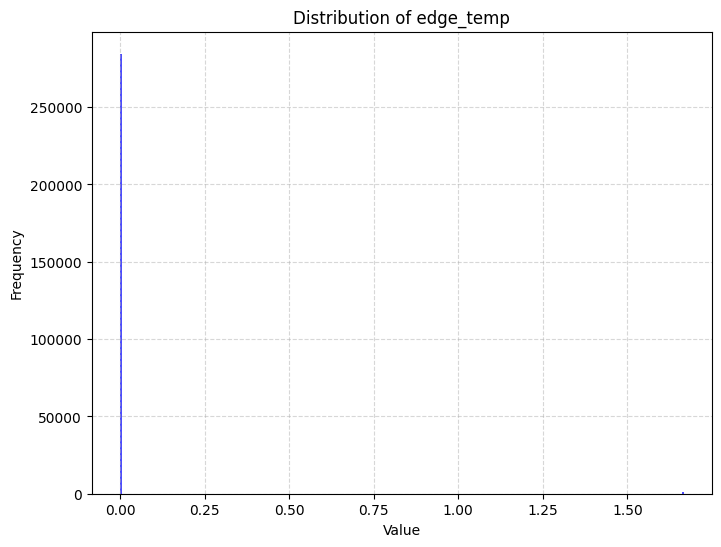

In [613]:
import torch
import matplotlib.pyplot as plt


# 将 tensor 转换为 numpy 数组以用于绘图
edge_temp_np = atten[1][:, 0].cpu().detach().numpy()

# 绘制分布图
plt.figure(figsize=(8, 6))
plt.hist(edge_temp_np, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of edge_temp')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [404]:
test_loader = DataLoader(test_graph, batch_size=1, shuffle=False, pin_memory=True)
model.eval()
test_loss = 0.0 

device = 'cuda:0'
model.to(device)

cell_type = []
test_barcodes = []
with torch.no_grad():
    cell_link_atten = []
    cell_link_activity = []
    cell_link_edge = []
    cell_link_enhancer = []
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_pre, atten, _ = model(sample.seq_data.to(device),
                                sample.x.to(device), 
                                sample.edge_index.to(device), 
                                sample.edge_tf.T.to(device), 
                                sample.batch.to(device), gene_num)
        test_barcodes.append(sample.cell)
        cell_type.append(sample.y.item())
        import torch

        # 对 model.edge.flatten() 进行 0-1 缩放
        edge_flattened = model.edge.flatten().to('cpu')
        min_val = torch.min(edge_flattened)
        max_val = torch.max(edge_flattened)
        normalized_edge = (edge_flattened - min_val) / (max_val - min_val + 1e-10)  # 防止除以 0

        # 将归一化后的张量添加到 cell_link_edge
        cell_link_edge.append(normalized_edge)
        print(atten)

        flattened_sample_x = sample.to(device).x[atten[0][1].cpu()].flatten()
        flattened_sample_enhancer = sample.to(device).x[atten[0][0].cpu()].flatten()
        atten1_max = torch.mean(atten[1], dim=1).to('cpu')
        cell_link_activity.append(flattened_sample_x.to('cpu'))
        cell_link_atten.append(atten1_max)
        cell_link_enhancer.append(flattened_sample_enhancer.to('cpu'))
#         edges = model.edge.flatten().cpu().numpy()
        torch.cuda.empty_cache()

Processing Batches:   0%|          | 0/3529 [00:00<?, ?it/s]


TypeError: forward() missing 1 required positional argument: 'gene_id_vec'

In [312]:
1

1

In [425]:
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [214]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [349]:
data_np = cell_link_activity.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

KeyboardInterrupt: 

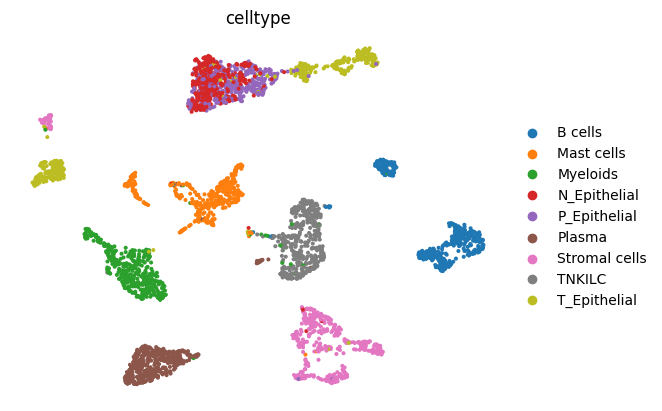

In [184]:
data_np = cell_link_enhancer.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

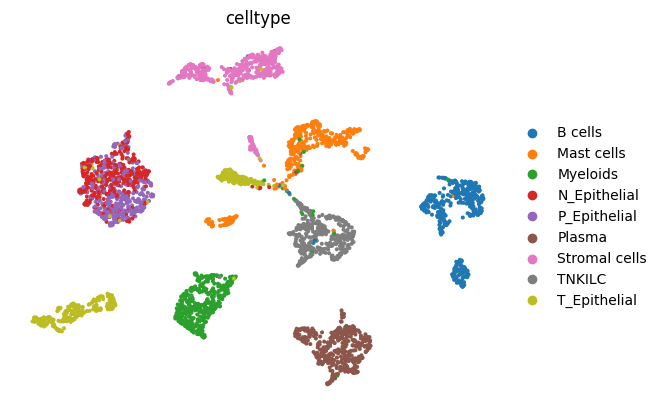

In [499]:
# Attention
data_np = cell_link_atten.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [ ]:
att

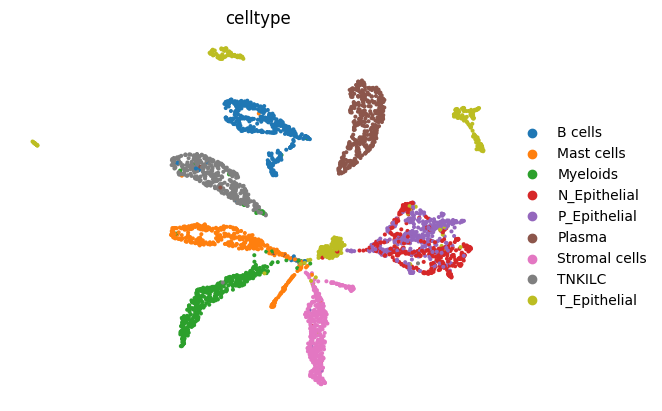

In [500]:
data_np = cell_link_edge.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [189]:
torch.max(cell_link_edge[0])

tensor(0.)

In [125]:
torch.save(cell_link_enhancer, 'cell_link_enhancer.pt')

In [123]:
torch.save(cell_link_atten, 'cell_link_atten.pt')

In [433]:
cpc_loop_df = pd.read_csv('./CPC_loops_overlap.csv', index_col=0)

In [436]:
insoveled_genes = pd.read_csv('./select_gene.txt')

In [443]:
insoveled_genes = insoveled_genes[insoveled_genes['cluster']  == 'T_Epithelial']['gene'].values

In [444]:
cpc_loop_df = cpc_loop_df[cpc_loop_df['Interaction Gene'].isin(insoveled_genes)]

In [445]:
cpc_loop_df['Gene_Chrom_Start_End'].values

array(['KIF1B-chr1-10398082-10398582', 'KIF1B-chr1-10398711-10399211',
       'KIF1B-chr1-10399311-10399811', ...,
       'RNF128-chrX-106042332-106042832',
       'GABRE-chrX-151359989-151360489',
       'BCAP31-chrX-153539405-153539905'], dtype=object)

In [71]:
temp_df = pd.read_csv('../test_fast//intersect_CRC_cellline_link.txt')

# Define a function to clean up the gene and chromosome location
def clean_location(entry):
    # Remove any unwanted characters
    return entry.strip("')")

# Clean the index and data
temp_df['Gene'] = temp_df.index.str.strip("('")
temp_df['Location'] = temp_df['x'].apply(clean_location)

# Drop the original 'x' column
temp_df = temp_df.drop(columns=['x'])

# Display the cleaned DataFrame
print(temp_df.head())
gene_list = [t.split('\'')[-1] for t in temp_df['Gene'].values]
peak_list = [t.split('\'')[0] for t in temp_df['Location'].values]
df = pd.DataFrame({'gene':gene_list, 'peak':peak_list})
df.head()

                   Gene                     Location
1 "('A2M'      1 "('A2M     chr12-8709390-8709890')"
2 "('A2M'      2 "('A2M     chr12-8709390-8709890')"
3 "('ABCA1'  3 "('ABCA1  chr9-107918652-107919152')"
4 "('ABCA1'  4 "('ABCA1  chr9-107929677-107930177')"
5 "('ABCA1'  5 "('ABCA1  chr9-107999805-108000305')"


,gene,peak
0,A2M,chr12-8709390-8709890
1,A2M,chr12-8709390-8709890
2,ABCA1,chr9-107918652-107919152
3,ABCA1,chr9-107929677-107930177
4,ABCA1,chr9-107999805-108000305


In [218]:
pos_dict = dict()
pos_dict_int = dict()
for idx, t in enumerate(dataset_atac.array_peak):
    pos_dict[t] = idx
    pos_dict_int[idx] = t
    
str_lists = []
for t in range(atten[0].shape[1]):
    str_lists.append(pos_dict_int[atten[0][1][t].item()] +  '-'  + pos_dict_int[atten[0][0][t].item()]) 

In [74]:
target_links = []
for t in df.values:
    target_links.append(t[0] + '-' + t[1])

In [447]:
from tqdm import tqdm

# Create a mapping of each string to its index
str_lists_index = {s: i for i, s in enumerate(str_lists)}

map_index = []
for t in tqdm(cpc_loop_df['Gene_Chrom_Start_End'].values, desc="Processing"):
    if t in str_lists_index:
        map_index.append(str_lists_index[t])


Processing: 100%|██████████| 8275/8275 [00:00<00:00, 639151.90it/s]


In [448]:
map_index = torch.tensor(map_index)

In [449]:
len(map_index)

8204

In [450]:
cell_type_cpu = dataset_atac.adata.obs.loc[test_barcodes]['celltype'].values

In [451]:
unique_celltype = np.unique(cell_type), np.unique(cell_type_cpu, return_counts=True)

In [452]:
unique_celltype = dataset_atac.array_celltype

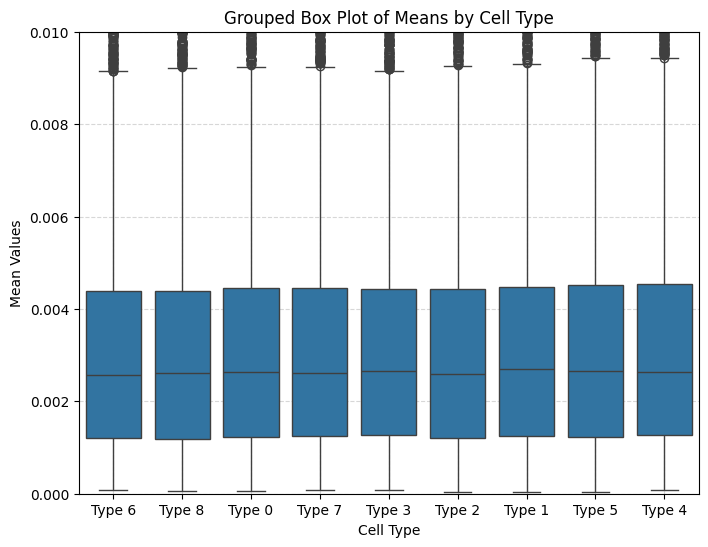

In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 获取numpy数组
temp_normalized = cell_link_atten[:, map_index].cpu().numpy() * cell_link_activity[:, map_index].cpu().numpy()

# 计算每个细胞类型组的均值
means = [np.mean(temp_normalized[cell_type_cpu == unique_celltype[i], :], axis=0) for i in range(len(unique_celltype))]

# 创建数据框并按均值排序
mean_data = {'Group': ['Type ' + str(i) for i in range(len(unique_celltype))],
             'Mean': [np.mean(m) for m in means]}
mean_df = pd.DataFrame(mean_data).sort_values(by='Mean')

# 准备用于绘图的数据
sorted_means = [means[int(group.split(' ')[1])] for group in mean_df['Group']]
data = {'Group': np.repeat(mean_df['Group'], [len(m) for m in sorted_means]),
        'Values': np.concatenate(sorted_means)}
df = pd.DataFrame(data)

# 创建箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Values', data=df, order=mean_df['Group'])
plt.title("Grouped Box Plot of Means by Cell Type")
plt.ylim(0, 0.01)
plt.ylabel("Mean Values")
plt.xlabel("Cell Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [469]:
dataset_atac.array_celltype

array(['B cells', 'Mast cells', 'Myeloids', 'N_Epithelial',
       'P_Epithelial', 'Plasma', 'Stromal cells', 'TNKILC',
       'T_Epithelial'], dtype=object)

In [464]:
cell_link_atten[0] 

tensor([0.0077, 0.0077, 0.0077,  ..., 0.0081, 0.0081, 0.0081])

In [470]:
cpc_loop_df

,Chromosome,Start Site,End Site,Interaction Gene,Gene_Chrom_Start_End
302,chr1,10398082,10398582,KIF1B,KIF1B-chr1-10398082-10398582
307,chr1,10398711,10399211,KIF1B,KIF1B-chr1-10398711-10399211
312,chr1,10399311,10399811,KIF1B,KIF1B-chr1-10399311-10399811
316,chr1,10399821,10400321,KIF1B,KIF1B-chr1-10399821-10400321
320,chr1,10400499,10400999,KIF1B,KIF1B-chr1-10400499-10400999
...,...,...,...,...,...
246275,chrX,106039877,106040377,RNF128,RNF128-chrX-106039877-106040377
246278,chrX,106039877,106040377,RNF128,RNF128-chrX-106039877-106040377
246279,chrX,106042332,106042832,RNF128,RNF128-chrX-106042332-106042832
247104,chrX,151359989,151360489,GABRE,GABRE-chrX-151359989-151360489


In [457]:
dataset_atac.array_celltype

array(['B cells', 'Mast cells', 'Myeloids', 'N_Epithelial',
       'P_Epithelial', 'Plasma', 'Stromal cells', 'TNKILC',
       'T_Epithelial'], dtype=object)

In [371]:
atten

tensor([0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101])

In [262]:
dataset_atac.array_celltype

array(['B cells', 'Mast cells', 'Myeloids', 'N_Epithelial',
       'P_Epithelial', 'Plasma', 'Stromal cells', 'TNKILC',
       'T_Epithelial'], dtype=object)

In [83]:
normalize_to_prob(model.data)

tensor([7.2317e-07, 6.8812e-07, 6.7725e-07,  ..., 4.8886e-06, 4.8886e-06,
        4.8886e-06], device='cuda:1', grad_fn=<DivBackward0>)

In [78]:
model.data

tensor([0.0252, 0.0240, 0.0236,  ..., 0.1704, 0.1704, 0.1704], device='cuda:1',
       grad_fn=<MeanBackward1>)

In [80]:
sample.y_exp

tensor([4.7479e-04, 1.0063e-03, 3.2451e-04,  ..., 1.2609e-05, 2.2495e-04,
        1.5094e-04])